In [1]:
import os
import gc
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from datetime import datetime, date
from collections import defaultdict
from multiprocessing import cpu_count, Pool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')

/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [3]:
pd.options.display.max_columns = None

In [4]:
PATH = os.path.join('..', 'remove_outlier_data')

KEY = 'card_id'

SEED = 6

NTHREAD = cpu_count()

NFOLD = 5

In [5]:
params = {
    'num_leaves': 31,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'feature_fraction': 0.6,
    'bagging_freq': 1,
    'bagging_fraction': 0.8,
    'bagging_seed': 11,
    'metric': 'rmse',
    'lambda_l1': 0.1,
    'verbosity': -1,
    'nthread': NTHREAD,
    'random_state': SEED
}

In [6]:
features = []

features += [f'f10{i}.pkl' for i in (2, 4,)]
features += [f'f11{i}_{j}.pkl' for i in (1, 2) 
                               for j in ('Y', 'N')]
features += [f'f12{i}.pkl' for i in (1,)]
features += [f'f13{i}.pkl' for i in (1, 2)]

features += [f'f20{i}.pkl' for i in (2,)]
features += [f'f23{i}.pkl' for i in (1, 2)]

features += [f'f30{i}.pkl' for i in (2, 3, 4,)]

In [7]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

for f in tqdm(features):
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    test = pd.merge(test, t, on=KEY, how='left')

100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


In [17]:
for c in train.columns:
    print(c)

first_active_month
card_id
feature_1
feature_2
feature_3
target
first_active_month_year
first_active_month_month
first_active_month_quarter
elapsed_time
days_feature_1
days_feature_2
days_feature_3
days_feature1_ratio
days_feature2_ratio
days_feature3_ratio
feature_sum
feature_mean
feature_max
feature_min
feature_var
hist_transactions_count
hist_category_1_sum
hist_category_1_mean
hist_category_2_nunique
hist_category_3_nunique
hist_merchant_id_nunique
hist_state_id_nunique
hist_subsector_id_nunique
hist_city_id_nunique
hist_merchant_category_id_nunique
hist_installments_nunique
hist_installments_mean
hist_installments_std
hist_installments_sum
hist_installments_exception_sum
hist_purchase_amount_sum
hist_purchase_amount_mean
hist_purchase_amount_max
hist_purchase_amount_min
hist_purchase_amount_std
hist_purchase_month_median
hist_purchase_month_max
hist_purchase_month_min
hist_purchase_month_std
hist_purchase_date_max
hist_purchase_date_min
hist_month_diff_max
hist_month_diff_min
hist

In [16]:
date_features=['hist_purchase_date_max','hist_purchase_date_min', 'new_purchase_date_max', 'new_purchase_date_min']

train['first_active_month'] = pd.to_datetime(train['first_active_month'])

for df in (train, test):
    for f in date_features:
        df[f] = pd.to_datetime(df[f])

    df['hist_first_buy'] = (df['hist_purchase_date_min'].dt.date - df['first_active_month'].dt.date).dt.days
#     df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
#     df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
#     df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

AttributeError: Can only use .dt accessor with datetimelike values

In [13]:
train['hist_purchase_date_min'].dt.date 

0         2017-06-27
1         2017-01-06
2         2017-01-11
3         2017-09-26
4         2017-11-12
5         2017-01-10
6         2017-01-05
7         2017-09-28
8         2017-08-18
9         2017-01-09
10        2017-04-03
11        2017-01-06
12        2017-09-12
13        2017-04-01
14        2017-08-09
15        2017-02-19
16        2017-01-13
17        2017-01-14
18        2017-11-11
19        2017-01-31
20        2017-09-28
21        2017-01-03
22        2017-09-12
23        2017-10-31
24        2017-01-14
25        2017-01-10
26        2017-07-28
27        2017-09-12
28        2017-01-13
29        2017-01-11
             ...    
201887    2017-01-06
201888    2017-01-04
201889    2017-07-10
201890    2017-01-01
201891    2017-01-13
201892    2017-04-20
201893    2017-10-26
201894    2017-01-07
201895    2017-01-12
201896    2017-01-15
201897    2017-01-06
201898    2017-06-15
201899    2017-10-23
201900    2017-07-01
201901    2017-05-13
201902    2017-01-27
201903    201

In [15]:
train['first_active_month']

0         2017-06-01
1         2017-01-01
2         2016-08-01
3         2017-09-01
4         2017-11-01
5         2016-09-01
6         2016-12-01
7         2017-09-01
8         2017-08-01
9         2016-08-01
10        2016-10-01
11        2016-03-01
12        2017-09-01
13        2017-04-01
14        2017-08-01
15        2017-02-01
16        2016-07-01
17        2016-12-01
18        2017-11-01
19        2017-01-01
20        2017-09-01
21        2016-06-01
22        2017-09-01
23        2017-10-01
24        2015-10-01
25        2016-04-01
26        2017-07-01
27        2017-09-01
28        2016-01-01
29        2016-06-01
             ...    
201887    2017-01-01
201888    2016-08-01
201889    2017-07-01
201890    2015-09-01
201891    2016-10-01
201892    2017-04-01
201893    2017-10-01
201894    2015-07-01
201895    2017-01-01
201896    2015-03-01
201897    2016-11-01
201898    2017-06-01
201899    2017-10-01
201900    2017-07-01
201901    2017-11-01
201902    2017-01-01
201903    201

In [76]:
cols = train.columns.values
for f in [
    'new_purchase_date_max', 'new_purchase_date_min',
    'hist_purchase_date_max', 'hist_purchase_date_min', 
    'Y_hist_auth_purchase_date_max', 'Y_hist_auth_purchase_date_min', 
    'N_hist_auth_purchase_date_max', 'N_hist_auth_purchase_date_min',
    'Y_new_auth_purchase_date_max', 'Y_new_auth_purchase_date_min', 
    'N_new_auth_purchase_date_max', 'N_new_auth_purchase_date_min',
]:
    if f in cols:
        train[f] = (train[f].astype(np.int64) * 1e-9).astype(np.int64)
        test[f] = (test[f].astype(np.int64) * 1e-9).astype(np.int64)

In [77]:
drop_cols = [
    'hist_cumsum_count_purchase_amount13', 'Y_new_auth_purchase_date_max',
    'Y_new_auth_purchase_date_min', 'N_new_auth_purchase_date_min'
]

for d in drop_cols:
    if f in cols:
        train.drop(d, axis=1, inplace=True)
        test.drop(d, axis=1, inplace=True)

In [78]:
train['nan_count'] = train.isnull().sum(axis=1)
test['nan_count'] = test.isnull().sum(axis=1)

train = train.fillna(0)
test = test.fillna(0)

y = train['target']

col_not_to_use = ['first_active_month', 'card_id', 'target']
col_to_use = [c for c in train.columns if c not in col_not_to_use]

train = train[col_to_use]
test = test[col_to_use]

train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)

gc.collect()

0

# hand crafted

In [79]:
X = train
X_test = test

In [80]:
# categorical_features = ['feature_1', 'feature_2', 'feature_3']
# X = pd.get_dummies(X, drop_first=True, columns=categorical_features)
# X_test = pd.get_dummies(X_test, drop_first=True, columns=categorical_features)

In [81]:
X.head()

,feature_1,feature_2,feature_3,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_merchant_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_merchant_category_id_nunique,hist_installments_nunique,hist_installments_mean,hist_installments_std,hist_installments_exception_sum,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_month_median,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_median,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_last_180_installments_mean,hist_last_180_installments_std,hist_last_180_purchase_amount_mean,hist_last_180_purchase_amount_std,hist_last_180_purchase_amount_sum,hist_last_30_installments_mean,hist_last_30_installments_std,hist_last_30_purchase_amount_mean,hist_last_30_purchase_amount_std,hist_last_30_purchase_amount_sum,hist_last_7_installments_mean,hist_last_7_installments_std,hist_last_7_purchase_amount_mean,hist_last_7_purchase_amount_std,hist_last_7_purchase_amount_sum,hist_last_90_installments_mean,hist_last_90_installments_std,hist_last_90_purchase_amount_mean,hist_last_90_purchase_amount_std,hist_last_90_purchase_amount_sum,Y_hist_auth_category_1_sum,Y_hist_auth_category_1_mean,Y_hist_auth_category_2_nunique,Y_hist_auth_category_3_nunique,Y_hist_auth_merchant_id_nunique,Y_hist_auth_state_id_nunique,Y_hist_auth_subsector_id_nunique,Y_hist_auth_city_id_nunique,Y_hist_auth_merchant_category_id_nunique,Y_hist_auth_installments_nunique,Y_hist_auth_installments_mean,Y_hist_auth_installments_std,Y_hist_auth_installments_exception_sum,Y_hist_auth_purchase_amount_sum,Y_hist_auth_purchase_amount_mean,Y_hist_auth_purchase_amount_max,Y_hist_auth_purchase_amount_min,Y_hist_auth_purchase_amount_std,Y_hist_auth_purchase_month_median,Y_hist_auth_purchase_month_max,Y_hist_auth_purchase_month_min,Y_hist_auth_purchase_month_std,Y_hist_auth_purchase_date_max,Y_hist_auth_purchase_date_min,Y_hist_auth_month_diff_median,Y_hist_auth_month_diff_max,Y_hist_auth_month_diff_min,Y_hist_auth_month_diff_std,Y_hist_auth_purchase_date_diff,Y_hist_auth_purchase_date_average,Y_hist_auth_purchase_date_uptonow,N_hist_auth_category_1_sum,N_hist_auth_category_1_mean,N_hist_auth_category_2_nunique,N_hist_auth_category_3_nunique,N_hist_auth_merchant_id_nunique,N_hist_auth_state_id_nunique,N_hist_auth_subsector_id_nunique,N_hist_auth_city_id_nunique,N_hist_auth_merchant_category_id_nunique,N_hist_auth_installments_nunique,N_hist_auth_installments_mean,N_hist_auth_installments_std,N_hist_auth_installments_exception_sum,N_hist_auth_purchase_amount_sum,N_hist_auth_purchase_amount_mean,N_hist_auth_purchase_amount_max,N_hist_auth_purchase_amount_min,N_hist_auth_purchase_amount_std,N_hist_auth_purchase_month_median,N_hist_auth_purchase_month_max,N_hist_auth_purchase_month_min,N_hist_auth_purchase_month_std,N_hist_auth_purchase_date_max,N_hist_auth_purchase_date_min,N_hist_auth_month_diff_median,N_hist_auth_month_diff_max,N_hist_auth_month_diff_min,N_hist_auth_month_diff_std,N_hist_auth_purchase_date_diff,N_hist_auth_purchase_date_average,N_hist_auth_purchase_date_uptonow,hist_Y_month_lag_mean,hist_Y_month_lag_std,hist_Y_purchase_amount_min_mean,hist_Y_purchase_amount_min_std,hist_Y_purchase_amount_max_mean,hist_Y_purchase_amount_max_std,hist_Y_purchase_amount_mean_mean,hist_Y_purchase_amount_mean_std,hist_Y_purchase_amount_std_mean,hist_Y_purchase_amount_std_std,hist_Y_installments_mean_mean,hist_Y_installments_mean_std,hist_Y_installments_sum_mean,hist_Y_installments_sum_std,hist_Y_installments_std_mean,hist_Y_installments_std_std,hist_N_month_lag_mean,hist_N_month_lag_std,hist_N_purchase_amount_min_mean,hist_N_purchase_amount_min_std,hist_N_purchase_amount_max_mean,his

In [82]:
folds = KFold(n_splits=NFOLD, shuffle=True, random_state=SEED)

oof = np.zeros(len(X))
prediction = np.zeros(len(X_test))

scores = []

feature_importance = pd.DataFrame()

for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
    dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])

    model = lgb.train(
        params,
        dtrain,
        20000,          
        valid_sets=[dtrain, dvalid],
        verbose_eval=200,
        early_stopping_rounds=20)
    
    y_pred_valid = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(np.sqrt(mean_squared_error(y.iloc[valid_index], y_pred_valid)))
    
    prediction += y_pred / folds.n_splits   

    fold_importance = pd.DataFrame()
    fold_importance['feature'] = X.columns
    fold_importance['importance'] = model.feature_importance()
    fold_importance['fold'] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

print('shape:', X.shape)
print('CV {0:} mean score: {1:.4f}, std: {2:.4f}, max: {3:.4f}, min: {4:.4f}.'.format(NFOLD, np.mean(scores), np.std(scores), np.max(scores), np.min(scores)))
print(features)

Training until validation scores don't improve for 20 rounds.
[200]	training's rmse: 3.59344	valid_1's rmse: 3.64227
[400]	training's rmse: 3.50068	valid_1's rmse: 3.62094
[600]	training's rmse: 3.4399	valid_1's rmse: 3.61313
Early stopping, best iteration is:
[707]	training's rmse: 3.41206	valid_1's rmse: 3.6113
Training until validation scores don't improve for 20 rounds.
[200]	training's rmse: 3.56997	valid_1's rmse: 3.73248
[400]	training's rmse: 3.47811	valid_1's rmse: 3.71038
[600]	training's rmse: 3.41601	valid_1's rmse: 3.70263
[800]	training's rmse: 3.36663	valid_1's rmse: 3.69905
Early stopping, best iteration is:
[843]	training's rmse: 3.35678	valid_1's rmse: 3.69842
Training until validation scores don't improve for 20 rounds.
[200]	training's rmse: 3.58037	valid_1's rmse: 3.6786
[400]	training's rmse: 3.48701	valid_1's rmse: 3.65715
[600]	training's rmse: 3.42593	valid_1's rmse: 3.64842
[800]	training's rmse: 3.37728	valid_1's rmse: 3.64445
[1000]	training's rmse: 3.3331	v

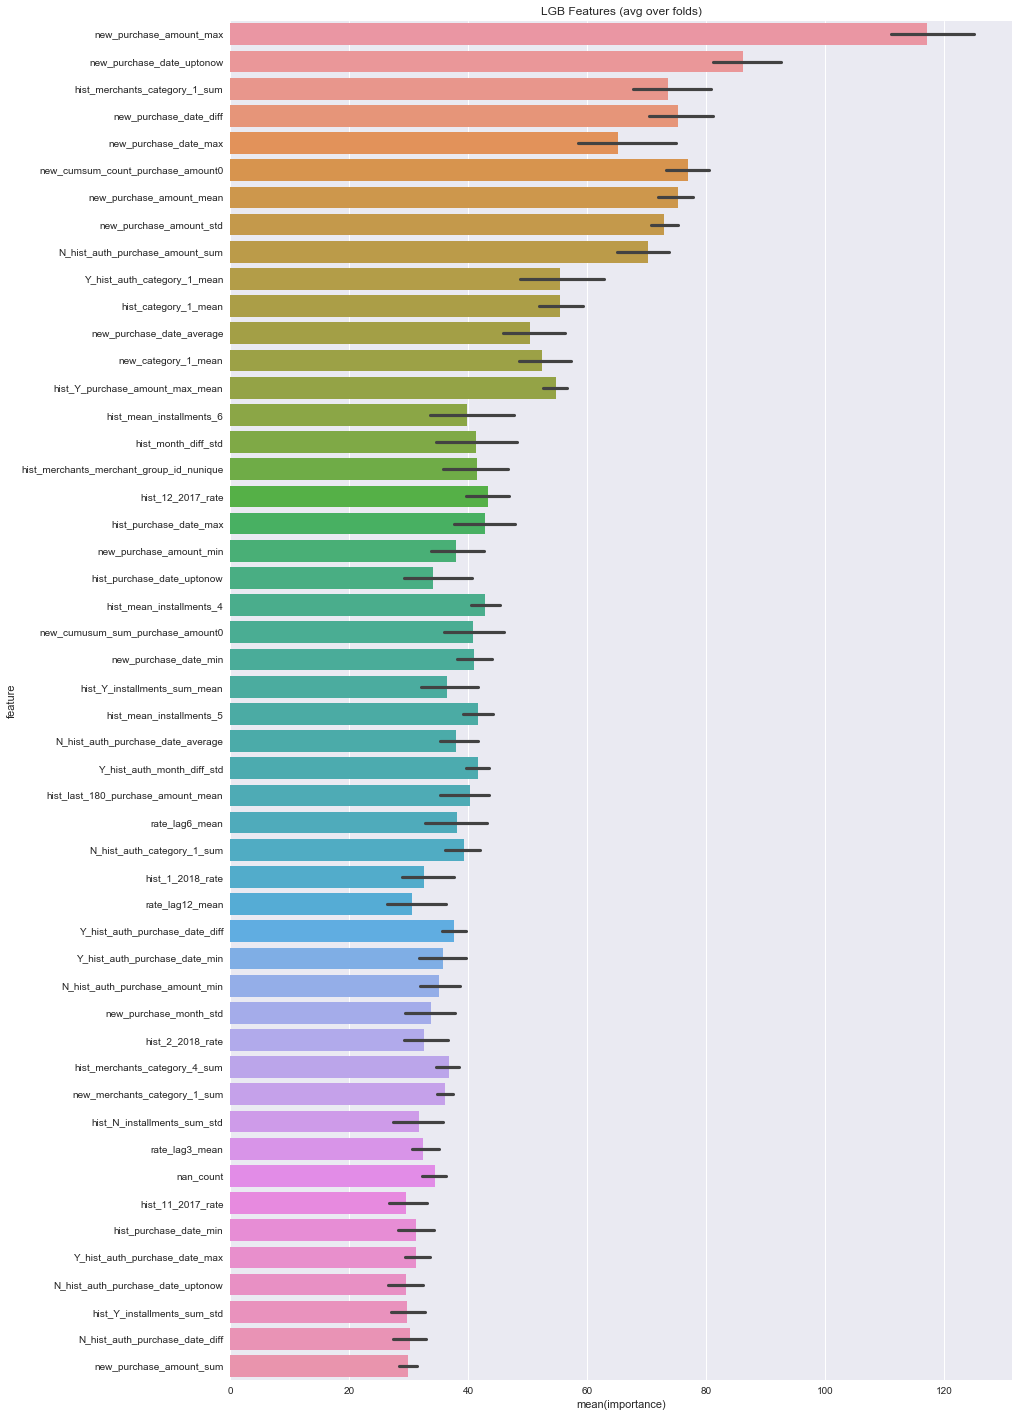

In [69]:
feature_importance['importance'] /= NFOLD
cols = feature_importance[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
best_features = best_features.sort_values(by='importance', ascending=False)

plt.figure(figsize=(14, 25))
plt.title('LGB Features (avg over folds)')
sns.barplot(x='importance', y='feature', data=best_features)
plt.show()